### Load Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.endpoints import leaguedashptstats

# makes the figures higher quality.
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

style.use("markerr.mplstyle")


### Load Synergy Play Type Data from NBA API

In [2]:
playtype_dfs = []
playtypes = [
    'Cut',
    'Handoff',
    'Isolation',
    'Misc',
    'OffScreen',
    'Postup',
    'PRBallHandler',
    'PRRollman',
    'OffRebound',
    'Spotup',
    'Transition',
]
for playtype in playtypes:
    playtype_df = synergyplaytypes.SynergyPlayTypes(
        league_id = '00', per_mode_simple = 'Totals',
        player_or_team_abbreviation = 'P', season_type_all_star = 'Regular Season',
        type_grouping_nullable = 'Offensive', play_type_nullable = playtype
    )
    playtype_dfs.append(playtype_df.synergy_play_type.get_data_frame())

all_playtypes = pd.concat(playtype_dfs).reset_index(drop = True)

### Limit Playtype Data to only Centers that have played more than 200 minutes

In [3]:
# load all the centers
centers = leaguedashptstats.LeagueDashPtStats(
    per_mode_simple = 'Totals', player_or_team= 'Player',
    player_position_abbreviation_nullable = 'C'
).get_data_frames()[0]
# limit to centers with more than 200 minutes
centers_over_200_mins = centers.loc[centers['MIN']>=200].PLAYER_ID.to_list()
all_playtypes_centers = all_playtypes.loc[all_playtypes['PLAYER_ID'].isin(centers_over_200_mins)].reset_index(drop = True)

In [4]:
def add_author_line(fig_, ax_, left_text, right_text, color_, pad_left_weight = .5, pad_right_weight = .5, pad_bottom = 0):
    chartBox = ax_.get_position()
    x0, y0, x1, y1 = chartBox.x0, chartBox.y0, chartBox.x1, chartBox.y1
    pad_left = (fig_.get_figwidth()*x0*pad_left_weight)
    pad_right = (1-x1)*fig_.get_figwidth()*pad_right_weight
    ax_.annotate('', xy=(-pad_left, -0.05+pad_bottom), xycoords='axes fraction', xytext=(1+pad_right, -0.05+pad_bottom), color = color_,
        arrowprops=dict(arrowstyle='-', color=color_))
    ax_.annotate(left_text, xy = (-pad_left, -0.1+pad_bottom), xycoords='axes fraction', 
        xytext = (-pad_left, -0.1+pad_bottom), horizontalalignment = 'left', color = color_,
            arrowprops=dict(arrowstyle='-', color='white'))
    ax_.annotate(right_text, xy = (1+pad_right, -0.1+pad_bottom), xycoords='axes fraction', 
        xytext = (1+pad_right, -0.1+pad_bottom), horizontalalignment = 'right', color = color_,
            arrowprops=dict(arrowstyle='-', color='white'))

### Graph

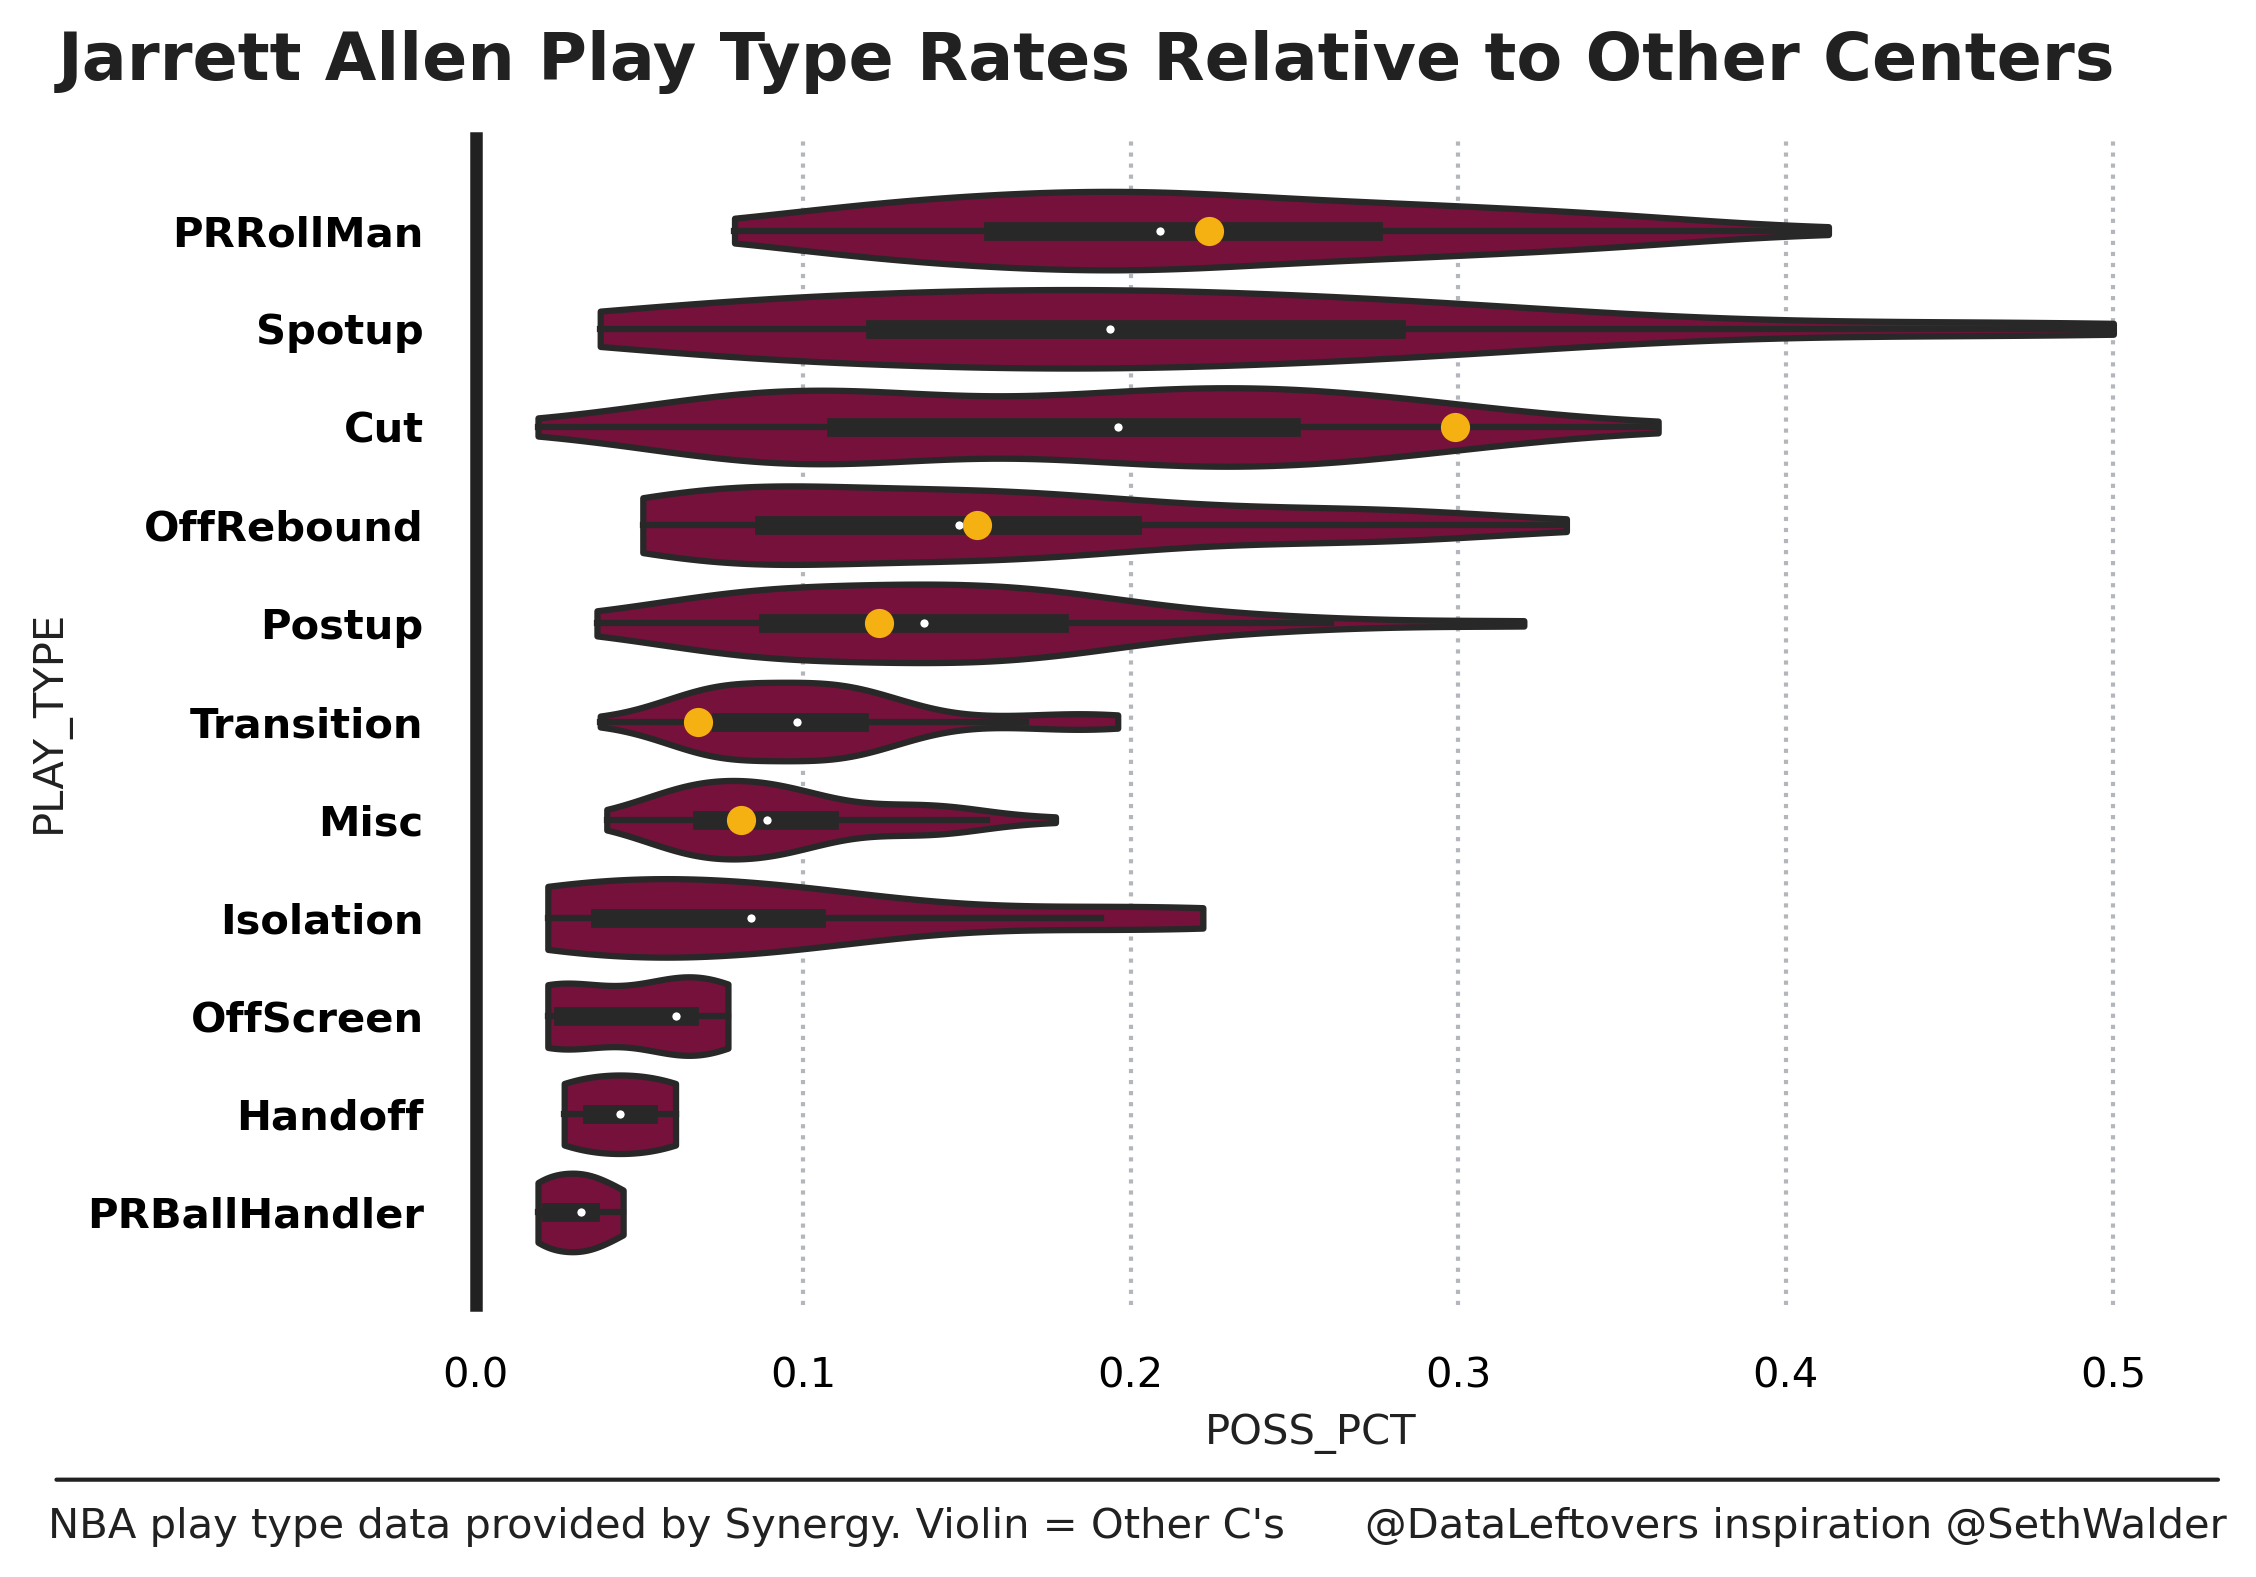

In [5]:
fig, ax = plt.subplots()
ordering = all_playtypes_centers.groupby('PLAY_TYPE').POSS_PCT.mean().sort_values(ascending = False).index
# graph violins
sns.violinplot(
    data = all_playtypes_centers, y = 'PLAY_TYPE', x = 'POSS_PCT', ax = ax, 
    cut = 0, scale = 'width', color = '#860038', 
    order = ordering
)
# graph the dots for Jarrett Allen
player_name = 'Jarrett Allen'
y_value_dict = dict(zip(ordering, range(len(ordering))))
for player_idx in all_playtypes_centers.loc[all_playtypes_centers['PLAYER_NAME']==player_name].index:
    ax.scatter(
        x = all_playtypes_centers.loc[player_idx, 'POSS_PCT'],
        y = y_value_dict[all_playtypes_centers.loc[player_idx, 'PLAY_TYPE']],
        zorder = 3,
        color = '#f5b112'
    )
ax.text(-.25, 1.05, f'{player_name} Play Type Rates Relative to Other Centers', 
    transform=ax.transAxes, ha="left", fontsize = 16, fontweight = 'bold', color = '#212121')
plt.xlim(0,.51)
# solid black line at the bottom of graph
ax.spines['left'].set_visible(True)
# make the highlighted features bold. should be the same side with the visible spine
plt.yticks(fontweight='bold')
add_author_line(
    fig, ax, 
    "NBA play type data provided by Synergy. Violin = Other C's", 
    '@DataLeftovers inspiration @SethWalder', '#212121', 
    pad_left_weight = .5, pad_right_weight = .15,
    pad_bottom = -.1)
plt.show()